# Projet Fil Rouge 2022 : Reconnaissance de commandes audio


**Noms :**

**Prénoms :**

**Nom du binôme :**




Ces six séances de TP vont vous permettre de tester l'algorithme de programmation dynamique vu en CTD puis de réaliser la mise en oeuvre d'un système de reconnaissance audio de mots isolés (constituant des
commandes pour les drones).

<img src="files/DroneJS.JPG" width="600" height="500"  >



Ces séances se décomposent en 4 parties : 
- Partie I : Prétraitement des données 
- Partie II : Sélection de variables et pénalisation
- Partie III : Classification par méthodes à noyau 
- Partie IV : Apprentissage par ensemble : Adaboost, gradient boosting
- Partie V : Classification par réseaux de neurones
- Partie VI : Votre étude




In [1]:
import matplotlib.pyplot as plt
import numpy as np
import scipy
import sklearn
import math
import numpy.random as rnd
import seaborn as sns

# Preprocessing

Sur l'espace moodle, vous trouverez un dossier d'enregistrements audio de mots de commandes pour un drone quadricoptère constitués de plusieurs locuteurs masculins (notés M01..M13) et locutrice féminines (F01..F05) pour quelques commandes. 


In [3]:
import librosa
from os import listdir
from os.path import isfile, join

Les lignes de code suivantes permettent de transformer le fichier audio en matrice de paramètres appélés MFCC (Mel Frequency Cepstral Coefficient) en utilisant la librairie python *librosa*. Ces paramètres permettent d'extraire au mieux le contenu vocal fréquenciel de signal audio.

La matrice de sortie est composée d'autant de vecteurs colonnes que de trames d'analyses. Le nombre de lignes correspond à la dimension du vecteur représentatif : ici 12.


In [ ]:
## Avec Google colab  
#from google.colab import files
#uploaded = files.upload()

# Prétraitement sur 1 fichier audio

In [30]:
y, sr = librosa.load("./FichierTest/M01_avance.wav")

**Calcul des MFCC**

 Pour chaque enregistrement audio, calculez le vecteur de  $\mathbb{R}^{12}$  égal à la moyenne sur toutes les fenêtres de MFCC. Ainsi chaque enregistrement sera représenté par un seul vecteur de 12 coefficients MFCC.

In [6]:
mfcc = librosa.feature.mfcc(y=y, sr=sr, hop_length=1024, htk=True, n_mfcc=12)
print("Nb Coeff MFCC x Nb Fenetres :",mfcc.shape)

Nb Coeff MFCC x Nb Fenetres : (12, 29)


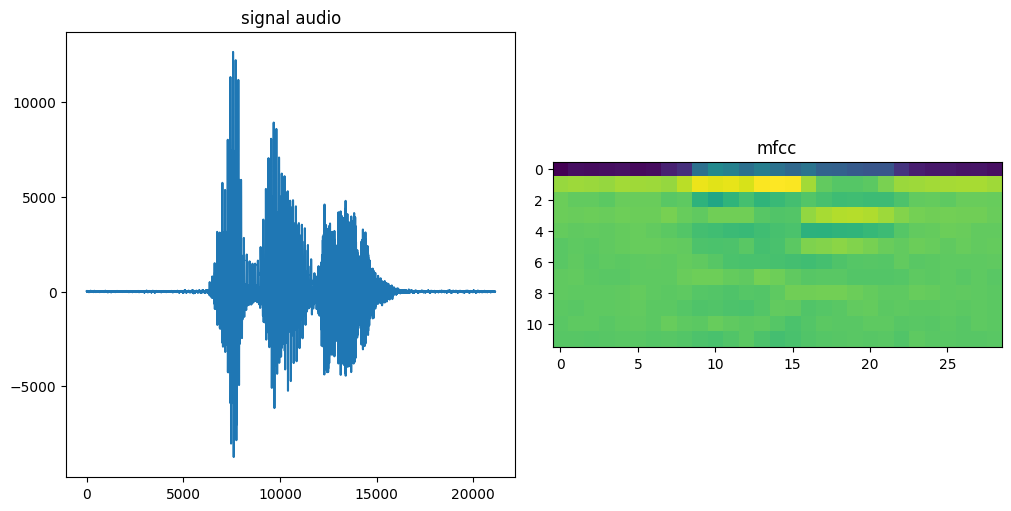

In [9]:
# Affichage du signal temporel 1D et des MFCC
from scipy.io.wavfile import read

input_data = read("./FichierTest/M01_avance.wav")
audio = input_data[1]

fig, axs = plt.subplots(1, 2, constrained_layout=True, figsize=(10,5))
axs[0].plot(audio)
axs[0].set_title('signal audio')

axs[1].imshow(mfcc)
axs[1].set_title('mfcc')

plt.show()

## Définition de la dimension à extraire  
Les enregistrements étant de durées différentes, il faut pouvoir comparer les données entre elles et donc procéder à un fenêtrage du signal.

In [12]:
Nb_SegmentMFCC = 12
Nb_SegmentSignal = 1000

In [15]:
# Fonction permettant de discrétiser le signal ou les mfcc, noté y, en Nb_segment 
# sur chaque fenêtre une statistique (moyenne, minimum ou maximum...) est extraite
def ReductionMemeDimension(y,Nb_Segment):
    Taille_y=len(y)
    Nouvelle_donnees=np.zeros((Nb_Segment,1))
    Nb_FenetreParSegment=math.floor(Taille_y/(Nb_Segment))

    for i in range(0,Nb_Segment):
        if len(y)==12:
            Nouvelle_donnees[i]=np.mean(y[:,i*Nb_FenetreParSegment:(i+1)*Nb_FenetreParSegment])
        else:
            Nouvelle_donnees[i]=np.max(y[i*Nb_FenetreParSegment:(i+1)*Nb_FenetreParSegment])

    return Nouvelle_donnees

In [16]:
# Test sur les mfcc et le signal à partir d'un fichier audio
DataMFCCReduc=ReductionMemeDimension(mfcc,Nb_SegmentMFCC)
DataSignalReduc=ReductionMemeDimension(y,Nb_SegmentSignal)

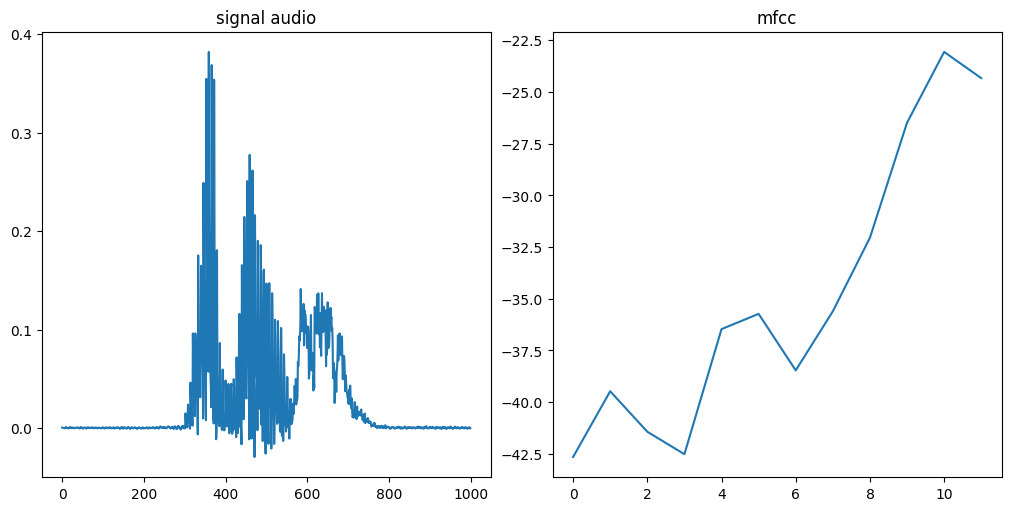

In [17]:
# Affichage de l'extraction 

fig, axs = plt.subplots(1, 2, constrained_layout=True, figsize=(10,5))
axs[0].plot(DataSignalReduc)
axs[0].set_title('signal audio')

axs[1].plot(DataMFCCReduc)
axs[1].set_title('mfcc')

plt.show()


## Création de la base d'apprentissage et de test 

In [18]:
# Nombre d'éléments dans la base d'Apprentissage et de Test
nbvalApp=38  # à changer si c'est autre dossier que FichierTest
nbvalTest= 16 # à changer si c'est autre dossier que FichierTest

In [21]:
#fichiers = [f for f in listdir("./FichierTest")] # à décommenter si Jupyter notebook

fichiers = [f for f in listdir("./FichierTest")] # à décommenter si chargé directement sur Google Colab
nb_fichier=len(fichiers)

fichiers=fichiers[1:nb_fichier-1] # à décommenter si c'est sur Google Colab

ListBaseApp=rnd.randint(0,nb_fichier-2,nbvalApp) # à choisir par exemple avec rnd.randint(0,nb_fichier,nbval)
ListBaseTest=rnd.randint(0,nb_fichier-2,nbvalTest)# à choisir

# Calcul des MFCC sur tous les fichiers de la base d'apprentissage
BaseApp=[]
BaseTest=[]
for i in range(len(ListBaseApp)):
    y, sr = librosa.load("./FichierTest/" + fichiers[ListBaseApp[i]])
    mfccBA = librosa.feature.mfcc(y=y, sr=sr, hop_length=1024, htk=True, n_mfcc=12)
    mfccBAReduc=ReductionMemeDimension(mfccBA,Nb_SegmentMFCC)
    BaseApp.append(mfccBAReduc)

for i in range(len(ListBaseTest)):
    y, sr = librosa.load("./FichierTest/" + fichiers[ListBaseTest[i]])
    mfccBT = librosa.feature.mfcc(y=y, sr=sr, hop_length=1024, htk=True, n_mfcc=12)
    mfccBTReduc=ReductionMemeDimension(mfccBT,Nb_SegmentMFCC)
    BaseTest.append(mfccBTReduc)

BaseApp=np.asarray(BaseApp)
BaseTest=np.asarray(BaseTest)
BaseApp=np.reshape(BaseApp,(nbvalApp,Nb_SegmentMFCC))
BaseTest=np.reshape(BaseTest,(nbvalTest,Nb_SegmentMFCC))

# Label des enregistrements : étiquettage des données via le nom du fichier .wav

In [22]:
import re

# fonction pour affecter une classe à chaque fichier audio 
def EtiquetterFichier(Fichier,ListeOrdre):
    NbFichier=len(Fichier)
    NbOrdre=len(ListeOrdre)
    NumClasse=np.zeros((NbOrdre,1))
    Classe=np.zeros((NbFichier,1))
    for NumF in range(NbFichier):
        for num in range(NbOrdre):
            pattern=ListeOrdre[num]
            #print(pattern)
            fileAudio=Fichier[NumF]
            result = re.search(pattern, fileAudio)
            if result:
                Classe[NumF]=num
    return Classe

In [23]:
# Test sur le dossier FichierTest
ListeOrdre=['avance','recule','tournegauche']
NbOrdre=len(ListeOrdre)
Label=EtiquetterFichier(fichiers,ListeOrdre)
LabelApp=np.ravel(Label[ListBaseApp])
LabelTest=np.ravel(Label[ListBaseTest])

# Partie I : Sélection de modèles et pénalisation

### 1. Régression Multiclasse

Appliquer un modèle de **régression multiclasses**.

On modélise les probabilités par la forme suivante :

$$
\mathbb{P}(Y_i = j) = \frac { \exp^{-\beta_j^{T} X_i } } { 1 + \sum_{\ell = 1}^{K-1} \exp^{-\beta_\ell^{T} X_i }}, 
$$
Pour tout $j$ dans $\{ 1,2, \dots , K-1 \}$.

On peut aussi considérer un modèle binomiale par classe pour l'analyse. i.e (Considérer les labels dans la classe $k$ comme étant 1 et les autres labels 0)

Pour votre étude, On vous proposera les comparaisons suivantes (liste exhaustive) : 

1. Essayer différents type d'optimiseurs disponibles dans la librairie Sklearn (lbfgs, saga, sag, newton-cg) et comparer la vitesse de convergence.

2. Faire varier le coefficient de régularisation $C$ (<span style="color:red"> **Il y a toujours une régularisation par défaut dans sklearn** </span>) et comparer son effet sur la performance.

3. Modèle binomiale versus Régression multinomiale. 

4. Le rescaling des donnés améliore t-il la performance ? 

In [25]:
# Modèle de régression 
from sklearn.linear_model import LogisticRegression

In [ ]:
LogisticRegression('')

###  Evaluation des résultats 

Evaluer le résultat par matrice de confusion et pourcentage de bonne classification.

*Conseil :* Pensez à mettre une fonction pour afficher la matrice de confusion

In [18]:
# Evaluation des résultats par matrices de confusion 
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix


# Partie II : Classification par méthodes à noyau

**Rappel** Les méthodes à noyau consistent à plonger les données dans un espace de dimension de Hilbert $\mathcal{H}$ ou les donnés pourront être séparé linéairement. 

**Theorème de Représentation :** La solution du problème de séparation en dimension infinie est contenue dans un sous espace vectoriel de dimension finie de $\mathcal{H}$ 

### 1. Réaliser une classification par SVM à noyau

    1) Varier le noyau
    2) Varier le paramètre de régularisation.


In [24]:
from sklearn.svm import SVC

### Approche non supervisée :  Classification spectrale 

 On peut aussi transposer à l'espace de Hilbert $\mathcal{H}$ des algos classiques de $\mathbb{R}^d$ comme la Classification spectrale.
 
 Réaliser une classification spectrale non supervisée sur les données. Interpréter les résultats 

In [20]:
from sklearn.cluster import SpectralClustering

# Partie III : Apprentissage par ensemble 

## 1. Adaptive Boosting : AdaBoost 

Adaboost repose sur la sélection itérative de classifieur faible en fonction d'une distribution des exemples d'apprentissage. Chaque exemple est pondéré en fonction de sa difficulté avec le classifieur courant. 

Réaliser une classification par adaboost et étudier 

In [ ]:
from sklearn.ensemble import AdaBoostClassifier

## 2. Gradient Boosting

Le Gradient Boosting permet l'optimisation de fonctions de perte différentiables arbitraires. Il permet d'optimiser la fonction de perte de l'apprenant précédent en ajoutant un nouveau modèle adaptatif qui combine des apprenants faibles.

Etudier sur la fonction de perte et le taux d'apprentissage.

In [21]:
from numba.core.types.containers import ListTypeIterableType
from sklearn.ensemble import GradientBoostingClassifier


### Evaluation de la classification

Utiliser la validation croisée pour évaluer les résultats 

In [22]:
from sklearn.model_selection import cross_val_score

# Partie IV : Classification par réseaux de neurones

1. Réaliser une classification via les réseaux de neurones
2. Evaluer les résultats par matrice de confusion par exemple, fonction de perte...
3. Tester différentes architectures et différents solveurs

In [23]:
from sklearn.neural_network import MLPClassifier


# Partie V : Votre étude 




Réalisez votre propre étude par binôme :
- en modifiant les bases de test et/ou d'apprentissage c'est-à-dire en créant  votre propre base d'apprentissage et votre base de test à partir du corpus et des voix et bruits que vous aurez enregistrés
- en rajoutant davantage de classes (jusqu'à 13 ordres vocaux disponibles) 
- en utilisant d'autres méthodes de réduction de dimension des MFCC (ACP,t-SNE)
le tout en testant les différentes approches et en interprétant les résultats, à synthétiser sur un rapport en pdf. 


**Paramètres pour enregistrements audio de vos voix perso:**

16 KHz, mono, 16 bits, format *.wav*